In [1]:
import configparser
import pickle
import sys
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ximc import XimcRedmine

config = configparser.ConfigParser()
config.read("config.ini")
user_name = config.get("MAIN", "login")
password = config.get("MAIN", "password")

try:
    ximc_user = XimcRedmine(user_name, password)
    ximc_user.auth()
except Exception:
    print("User authorization failed")
    sys.exit(0)

# Задаем параметры для первого запроса (фильтры задаются аналогично веб-интерфейсу ximc)
ximc_user.add_filter("Проект", "соответствует", "EP-software")
ximc_user.add_filter("Статус", "соответствует", "Closed")
ximc_user.add_filter("Трекер", "не соответствует", "Bug")
ximc_user.add_filter("Приоритет", "соответствует", "Normal")
ximc_user.add_filter("Автор", "не соответствует", "dasha")
ximc_user.add_filter("Назначена", "все")
ximc_user.add_filter("Версия", "соответствует", "Развитие-2018")
ximc_user.add_filter("Тема", "содержит", "к нашим")
ximc_user.add_filter("Описание", "начинается с", "Привести")
ximc_user.add_filter("Готовность", ">=", 50)
ximc_user.add_filter("Частная", "соответствует", "нет")
ximc_user.add_filter("Файл", "отсутствует")
ximc_user.add_filter("Кем изменено", "соответствует", "mikheev")
ximc_user.add_filter("Последний изменивший", "соответствует", "VladBelov")
ximc_user.add_filter("Задача", ">=", 20033)
# Запрашиваем необходимые итоговые параметры
totals = ximc_user.get_totals("Оценка временных затрат", "Трудозатраты", "Payment cash", "Payment cashless", "Rate")
# В итоге получаем словарь в виде: {"название параметра": значение}
print("Project: EP-software")
totals_options = "Оценка временных затрат", "Трудозатраты", "Payment cash", "Payment cashless", "Rate"
table = [(option, totals[option]) for option in totals_options]
pd.set_option('display.max_columns', None)
df = pd.DataFrame(table, columns=("Параметр", "Значение"))
print(df)

# Задаем параметры для следующего запроса. Но сначала нужно очистить ранее заданные фильтры
ximc_user.clear_filters()
# Задаем фильтры аналогично веб-интерфейсу ximc
ximc_user.add_filter("Project", "is", "Payments")
ximc_user.add_filter("Status", "closed")
ximc_user.add_filter("Created", "between", "2021-09-09", "2021-11-11")
# Запрашиваем необходимые итоговые параметры
totals = ximc_user.get_totals("Estimated time", "Spent time", "Payment cash", "Payment cashless", "Rate", "Payment tail")
# В итоге получаем словарь в виде: {"название параметра": значение}
print("\nProject: Payments")
for option_name, value in totals.items():
    print(f"{option_name}: {value}")

# Задаем параметры для следующего запроса. Но сначала нужно очистить ранее заданные фильтры
ximc_user.clear_filters()
ximc_user.add_filter("Status", "is", "Closed")
ximc_user.add_filter("Tracker", "is not", "Bug")
ximc_user.add_filter("Priority", "is", "Normal")
ximc_user.add_filter("Author", "is", "dasha")
ximc_user.add_filter("Assignee", "is", "vladimirov_iy")
ximc_user.add_filter("% Done", ">=", 50)
# Запрашиваем необходимые итоговые параметры
totals = ximc_user.get_totals("Estimated time", "Spent time", "Payment cash", "Payment cashless", "Rate")
# В итоге получаем словарь в виде: {"название параметра": значение}
print("\nAll projects")
for option_name, value in totals.items():
    print(f"{option_name}: {value}")

Project: EP-software
                  Параметр  Значение
0  Оценка временных затрат      3.00
1             Трудозатраты     16.35
2             Payment cash      0.00
3         Payment cashless      0.00
4                     Rate      0.00

Project: Payments
Estimated time: 0.0
Spent time: 0.0
Payment cash: 9150207.0
Payment cashless: 3766329.0
Rate: 129248.0
Payment tail: -301529.0

All projects
Estimated time: 0.0
Spent time: 0.0
Payment cash: 6400.0
Payment cashless: 0.0
Rate: 500.0


In [2]:
# Имена проектов, для которых будем сравнивать данные
project_names = [project_name for _, project_name in ximc_user.get_projects()]
# Перебираем проекты из списка и получаем для них данные с применением фильтров
START_TIME = datetime.strptime("2020-01-01", "%Y-%m-%d")
END_TIME = datetime.strptime("2021-12-31", "%Y-%m-%d")
result = {}
for project_name in project_names:
    result_for_project = []
    print(f"\nПроект: {project_name}")
    start_time = START_TIME
    while start_time < END_TIME:    
        start_time_in_str = start_time.strftime("%Y-%m-%d")
        end_time = start_time + timedelta(days=30)
        end_time_in_str = end_time.strftime("%Y-%m-%d")
        # Задаем фильтры аналогично веб-интерфейсу ximc
        ximc_user.clear_filters()
        ximc_user.add_filter("Project", "is", project_name)
        ximc_user.add_filter("Status", "is", "Closed")
        ximc_user.add_filter("Tracker", "is not", "Bug")
        ximc_user.add_filter("Created", ">=", start_time_in_str)
        ximc_user.add_filter("Created", "<=", end_time_in_str)
        # Запрашиваем необходимые итоговые параметры
        totals = ximc_user.get_totals("Оценка временных затрат", "Трудозатраты")
        if totals["Оценка временных затрат"] is None:
            estimated_time = 0
        else:
            estimated_time = totals["Оценка временных затрат"]
        if totals["Трудозатраты"] is None:
            spent_time = 0
        else:
            spent_time = totals["Трудозатраты"]
        result_for_project_in_given_period = {"start_time": start_time, "end_time": end_time,
                                              "estimated_time": estimated_time, "spent_time": spent_time}
        result_for_project.append(result_for_project_in_given_period)
        start_time = end_time
        print(f"в период с {start_time_in_str} по {end_time_in_str}: оценка временных затрат = {estimated_time} ч, "
              f"трудозатраты = {spent_time} ч")
    result[project_name] = result_for_project

# Сохраняем результат в файл
FILE_FOR_RESULT = "result.pickle"
with open(FILE_FOR_RESULT, "wb") as file:
    pickle.dump(result, file)


Проект: 0MALT
в период с 2020-01-01 по 2020-01-31: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-01-31 по 2020-03-01: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-03-01 по 2020-03-31: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-03-31 по 2020-04-30: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-04-30 по 2020-05-30: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-05-30 по 2020-06-29: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-06-29 по 2020-07-29: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-07-29 по 2020-08-28: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-08-28 по 2020-09-27: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-09-27 по 2020-10-27: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-10-27 по 2020-11-26: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-11-26 по 202

в период с 2021-05-25 по 2021-06-24: оценка временных затрат = 85.0 ч, трудозатраты = 503.0 ч
в период с 2021-06-24 по 2021-07-24: оценка временных затрат = 93.0 ч, трудозатраты = 505.0 ч
в период с 2021-07-24 по 2021-08-23: оценка временных затрат = 93.0 ч, трудозатраты = 505.0 ч
в период с 2021-08-23 по 2021-09-22: оценка временных затрат = 93.0 ч, трудозатраты = 505.0 ч
в период с 2021-09-22 по 2021-10-22: оценка временных затрат = 101.0 ч, трудозатраты = 507.0 ч
в период с 2021-10-22 по 2021-11-21: оценка временных затрат = 101.0 ч, трудозатраты = 507.0 ч
в период с 2021-11-21 по 2021-12-21: оценка временных затрат = 101.0 ч, трудозатраты = 507.0 ч
в период с 2021-12-21 по 2022-01-20: оценка временных затрат = 161.0 ч, трудозатраты = 566.01 ч

Проект: ADC-econom
в период с 2020-01-01 по 2020-01-31: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-01-31 по 2020-03-01: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-03-01 по 2020-03-31: оценка време

в период с 2020-07-29 по 2020-08-28: оценка временных затрат = 887.0 ч, трудозатраты = 968.0 ч
в период с 2020-08-28 по 2020-09-27: оценка временных затрат = 903.0 ч, трудозатраты = 1022.0 ч
в период с 2020-09-27 по 2020-10-27: оценка временных затрат = 923.0 ч, трудозатраты = 1079.5 ч
в период с 2020-10-27 по 2020-11-26: оценка временных затрат = 943.0 ч, трудозатраты = 1096.0 ч
в период с 2020-11-26 по 2020-12-26: оценка временных затрат = 1103.0 ч, трудозатраты = 1723.0 ч
в период с 2020-12-26 по 2021-01-25: оценка временных затрат = 1103.0 ч, трудозатраты = 1723.0 ч
в период с 2021-01-25 по 2021-02-24: оценка временных затрат = 1103.0 ч, трудозатраты = 1723.0 ч
в период с 2021-02-24 по 2021-03-26: оценка временных затрат = 1113.0 ч, трудозатраты = 1727.0 ч
в период с 2021-03-26 по 2021-04-25: оценка временных затрат = 1113.0 ч, трудозатраты = 1727.0 ч
в период с 2021-04-25 по 2021-05-25: оценка временных затрат = 1113.0 ч, трудозатраты = 1727.0 ч
в период с 2021-05-25 по 2021-06-24

в период с 2021-09-22 по 2021-10-22: оценка временных затрат = 691.0 ч, трудозатраты = 1639.07 ч
в период с 2021-10-22 по 2021-11-21: оценка временных затрат = 855.0 ч, трудозатраты = 1925.07 ч
в период с 2021-11-21 по 2021-12-21: оценка временных затрат = 1124.0 ч, трудозатраты = 2174.07 ч
в период с 2021-12-21 по 2022-01-20: оценка временных затрат = 1304.0 ч, трудозатраты = 2404.63 ч

Проект: Burg-2
в период с 2020-01-01 по 2020-01-31: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-01-31 по 2020-03-01: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-03-01 по 2020-03-31: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-03-31 по 2020-04-30: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-04-30 по 2020-05-30: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-05-30 по 2020-06-29: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-06-29 по 2020-07-29: оценка временных затрат = 0 ч, труд

в период с 2020-09-27 по 2020-10-27: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-10-27 по 2020-11-26: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-11-26 по 2020-12-26: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-12-26 по 2021-01-25: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-01-25 по 2021-02-24: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-02-24 по 2021-03-26: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-03-26 по 2021-04-25: оценка временных затрат = 10.0 ч, трудозатраты = 4.0 ч
в период с 2021-04-25 по 2021-05-25: оценка временных затрат = 10.0 ч, трудозатраты = 4.0 ч
в период с 2021-05-25 по 2021-06-24: оценка временных затрат = 10.0 ч, трудозатраты = 4.0 ч
в период с 2021-06-24 по 2021-07-24: оценка временных затрат = 10.0 ч, трудозатраты = 4.0 ч
в период с 2021-07-24 по 2021-08-23: оценка временных затрат = 10.0 ч, трудозатраты = 4.0 ч
в период с 2021-08

в период с 2020-01-01 по 2020-01-31: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-01-31 по 2020-03-01: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-03-01 по 2020-03-31: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-03-31 по 2020-04-30: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-04-30 по 2020-05-30: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-05-30 по 2020-06-29: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-06-29 по 2020-07-29: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-07-29 по 2020-08-28: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-08-28 по 2020-09-27: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-09-27 по 2020-10-27: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-10-27 по 2020-11-26: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-11-26 по 2020-12-26: оценка

в период с 2021-07-24 по 2021-08-23: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-08-23 по 2021-09-22: оценка временных затрат = 8.0 ч, трудозатраты = 11.9 ч
в период с 2021-09-22 по 2021-10-22: оценка временных затрат = 28.0 ч, трудозатраты = 27.4 ч
в период с 2021-10-22 по 2021-11-21: оценка временных затрат = 28.0 ч, трудозатраты = 27.4 ч
в период с 2021-11-21 по 2021-12-21: оценка временных затрат = 36.0 ч, трудозатраты = 38.1 ч
в период с 2021-12-21 по 2022-01-20: оценка временных затрат = 36.0 ч, трудозатраты = 38.1 ч

Проект: DAC-payments
в период с 2020-01-01 по 2020-01-31: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-01-31 по 2020-03-01: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-03-01 по 2020-03-31: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-03-31 по 2020-04-30: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-04-30 по 2020-05-30: оценка временных затрат = 0 ч, трудозатрат

в период с 2020-12-26 по 2021-01-25: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-01-25 по 2021-02-24: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-02-24 по 2021-03-26: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-03-26 по 2021-04-25: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-04-25 по 2021-05-25: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-05-25 по 2021-06-24: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-06-24 по 2021-07-24: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-07-24 по 2021-08-23: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-08-23 по 2021-09-22: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-09-22 по 2021-10-22: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-10-22 по 2021-11-21: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-11-21 по 2021-12-21: оценка

в период с 2020-04-30 по 2020-05-30: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-05-30 по 2020-06-29: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-06-29 по 2020-07-29: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-07-29 по 2020-08-28: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-08-28 по 2020-09-27: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-09-27 по 2020-10-27: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-10-27 по 2020-11-26: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-11-26 по 2020-12-26: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-12-26 по 2021-01-25: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-01-25 по 2021-02-24: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-02-24 по 2021-03-26: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-03-26 по 2021-04-25: оценка

в период с 2021-07-24 по 2021-08-23: оценка временных затрат = 60.0 ч, трудозатраты = 99.16 ч
в период с 2021-08-23 по 2021-09-22: оценка временных затрат = 60.0 ч, трудозатраты = 99.16 ч
в период с 2021-09-22 по 2021-10-22: оценка временных затрат = 60.0 ч, трудозатраты = 99.16 ч
в период с 2021-10-22 по 2021-11-21: оценка временных затрат = 60.0 ч, трудозатраты = 99.16 ч
в период с 2021-11-21 по 2021-12-21: оценка временных затрат = 60.0 ч, трудозатраты = 99.16 ч
в период с 2021-12-21 по 2022-01-20: оценка временных затрат = 60.0 ч, трудозатраты = 99.16 ч

Проект: DPLL-soft
в период с 2020-01-01 по 2020-01-31: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-01-31 по 2020-03-01: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-03-01 по 2020-03-31: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-03-31 по 2020-04-30: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-04-30 по 2020-05-30: оценка временных затрат = 15.0 ч

в период с 2020-07-29 по 2020-08-28: оценка временных затрат = 83.0 ч, трудозатраты = 652.41 ч
в период с 2020-08-28 по 2020-09-27: оценка временных затрат = 89.0 ч, трудозатраты = 658.41 ч
в период с 2020-09-27 по 2020-10-27: оценка временных затрат = 115.5 ч, трудозатраты = 710.98 ч
в период с 2020-10-27 по 2020-11-26: оценка временных затрат = 179.5 ч, трудозатраты = 847.78 ч
в период с 2020-11-26 по 2020-12-26: оценка временных затрат = 289.5 ч, трудозатраты = 948.28 ч
в период с 2020-12-26 по 2021-01-25: оценка временных затрат = 289.5 ч, трудозатраты = 948.28 ч
в период с 2021-01-25 по 2021-02-24: оценка временных затрат = 309.5 ч, трудозатраты = 954.28 ч
в период с 2021-02-24 по 2021-03-26: оценка временных затрат = 348.5 ч, трудозатраты = 997.53 ч
в период с 2021-03-26 по 2021-04-25: оценка временных затрат = 427.5 ч, трудозатраты = 1211.43 ч
в период с 2021-04-25 по 2021-05-25: оценка временных затрат = 510.5 ч, трудозатраты = 1291.43 ч
в период с 2021-05-25 по 2021-06-24: оце

в период с 2021-09-22 по 2021-10-22: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2021-10-22 по 2021-11-21: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2021-11-21 по 2021-12-21: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2021-12-21 по 2022-01-20: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч

Проект: Freon-soft
в период с 2020-01-01 по 2020-01-31: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-01-31 по 2020-03-01: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-03-01 по 2020-03-31: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-03-31 по 2020-04-30: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-04-30 по 2020-05-30: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-05-30 по 2020-06-29: оценка временных затрат = 80.0 ч, трудозатраты = 146.1 ч
в период с 2020-06-29 по 2020-07-29: оценка временных затрат = 110.0 ч, трудозатраты = 

в период с 2020-12-26 по 2021-01-25: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-01-25 по 2021-02-24: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-02-24 по 2021-03-26: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-03-26 по 2021-04-25: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-04-25 по 2021-05-25: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-05-25 по 2021-06-24: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-06-24 по 2021-07-24: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-07-24 по 2021-08-23: оценка временных затрат = 40.0 ч, трудозатраты = 32.0 ч
в период с 2021-08-23 по 2021-09-22: оценка временных затрат = 52.0 ч, трудозатраты = 39.0 ч
в период с 2021-09-22 по 2021-10-22: оценка временных затрат = 52.0 ч, трудозатраты = 39.0 ч
в период с 2021-10-22 по 2021-11-21: оценка временных затрат = 52.0 ч, трудозатраты = 39.0 ч
в период с 2021-11-

в период с 2020-05-30 по 2020-06-29: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-06-29 по 2020-07-29: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-07-29 по 2020-08-28: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-08-28 по 2020-09-27: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-09-27 по 2020-10-27: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-10-27 по 2020-11-26: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-11-26 по 2020-12-26: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-12-26 по 2021-01-25: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-01-25 по 2021-02-24: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-02-24 по 2021-03-26: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-03-26 по 2021-04-25: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-04-25 по 2021-05-25: оценка

в период с 2021-12-21 по 2022-01-20: оценка временных затрат = 0 ч, трудозатраты = 0 ч

Проект: NPU
в период с 2020-01-01 по 2020-01-31: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-01-31 по 2020-03-01: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-03-01 по 2020-03-31: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-03-31 по 2020-04-30: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-04-30 по 2020-05-30: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-05-30 по 2020-06-29: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-06-29 по 2020-07-29: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-07-29 по 2020-08-28: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-08-28 по 2020-09-27: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-09-27 по 2020-10-27: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-10-27 по 2020-

в период с 2021-05-25 по 2021-06-24: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-06-24 по 2021-07-24: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-07-24 по 2021-08-23: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-08-23 по 2021-09-22: оценка временных затрат = 0.0 ч, трудозатраты = 2.0 ч
в период с 2021-09-22 по 2021-10-22: оценка временных затрат = 30.0 ч, трудозатраты = 47.0 ч
в период с 2021-10-22 по 2021-11-21: оценка временных затрат = 30.0 ч, трудозатраты = 47.0 ч
в период с 2021-11-21 по 2021-12-21: оценка временных затрат = 60.0 ч, трудозатраты = 72.0 ч
в период с 2021-12-21 по 2022-01-20: оценка временных затрат = 60.0 ч, трудозатраты = 72.0 ч

Проект: NPU-payments
в период с 2020-01-01 по 2020-01-31: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-01-31 по 2020-03-01: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-03-01 по 2020-03-31: оценка временных затрат = 0 ч, трудозатраты

в период с 2020-05-30 по 2020-06-29: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-06-29 по 2020-07-29: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-07-29 по 2020-08-28: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-08-28 по 2020-09-27: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-09-27 по 2020-10-27: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-10-27 по 2020-11-26: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-11-26 по 2020-12-26: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-12-26 по 2021-01-25: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-01-25 по 2021-02-24: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-02-24 по 2021-03-26: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-03-26 по 2021-04-25: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-04-25 по 2021-05-25: оценка

в период с 2021-08-23 по 2021-09-22: оценка временных затрат = 476.0 ч, трудозатраты = 653.19 ч
в период с 2021-09-22 по 2021-10-22: оценка временных затрат = 593.0 ч, трудозатраты = 837.59 ч
в период с 2021-10-22 по 2021-11-21: оценка временных затрат = 722.0 ч, трудозатраты = 993.2 ч
в период с 2021-11-21 по 2021-12-21: оценка временных затрат = 840.0 ч, трудозатраты = 1127.7 ч
в период с 2021-12-21 по 2022-01-20: оценка временных затрат = 912.5 ч, трудозатраты = 1223.4 ч

Проект: Open-analog
в период с 2020-01-01 по 2020-01-31: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-01-31 по 2020-03-01: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-03-01 по 2020-03-31: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-03-31 по 2020-04-30: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-04-30 по 2020-05-30: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-05-30 по 2020-06-29: оценка временных затрат = 0 

в период с 2020-10-27 по 2020-11-26: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-11-26 по 2020-12-26: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-12-26 по 2021-01-25: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-01-25 по 2021-02-24: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-02-24 по 2021-03-26: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-03-26 по 2021-04-25: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-04-25 по 2021-05-25: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-05-25 по 2021-06-24: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-06-24 по 2021-07-24: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-07-24 по 2021-08-23: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-08-23 по 2021-09-22: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-09-22 по 2021-10-22: оценка

в период с 2021-12-21 по 2022-01-20: оценка временных затрат = 713.0 ч, трудозатраты = 534.33 ч

Проект: Open-service
в период с 2020-01-01 по 2020-01-31: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-01-31 по 2020-03-01: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-03-01 по 2020-03-31: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-03-31 по 2020-04-30: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-04-30 по 2020-05-30: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-05-30 по 2020-06-29: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-06-29 по 2020-07-29: оценка временных затрат = 8.0 ч, трудозатраты = 9.2 ч
в период с 2020-07-29 по 2020-08-28: оценка временных затрат = 8.0 ч, трудозатраты = 9.2 ч
в период с 2020-08-28 по 2020-09-27: оценка временных затрат = 18.0 ч, трудозатраты = 16.5 ч
в период с 2020-09-27 по 2020-10-27: оценка временных затрат = 22.0 ч, трудозатраты =

в период с 2020-12-26 по 2021-01-25: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-01-25 по 2021-02-24: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-02-24 по 2021-03-26: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-03-26 по 2021-04-25: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-04-25 по 2021-05-25: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-05-25 по 2021-06-24: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-06-24 по 2021-07-24: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-07-24 по 2021-08-23: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-08-23 по 2021-09-22: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-09-22 по 2021-10-22: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-10-22 по 2021-11-21: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-11-21 по 2021-12-21: оценка

в период с 2020-05-30 по 2020-06-29: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-06-29 по 2020-07-29: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-07-29 по 2020-08-28: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-08-28 по 2020-09-27: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-09-27 по 2020-10-27: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-10-27 по 2020-11-26: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-11-26 по 2020-12-26: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-12-26 по 2021-01-25: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-01-25 по 2021-02-24: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-02-24 по 2021-03-26: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-03-26 по 2021-04-25: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-04-25 по 2021-05-25: оценка

в период с 2021-10-22 по 2021-11-21: оценка временных затрат = 78.0 ч, трудозатраты = 49.25 ч
в период с 2021-11-21 по 2021-12-21: оценка временных затрат = 78.0 ч, трудозатраты = 49.25 ч
в период с 2021-12-21 по 2022-01-20: оценка временных затрат = 80.0 ч, трудозатраты = 60.35 ч

Проект: PIC-topology
в период с 2020-01-01 по 2020-01-31: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-01-31 по 2020-03-01: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-03-01 по 2020-03-31: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-03-31 по 2020-04-30: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-04-30 по 2020-05-30: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-05-30 по 2020-06-29: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-06-29 по 2020-07-29: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-07-29 по 2020-08-28: оценка временных затрат = 0 ч, трудозатраты = 0 ч


в период с 2021-02-24 по 2021-03-26: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-03-26 по 2021-04-25: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2021-04-25 по 2021-05-25: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2021-05-25 по 2021-06-24: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2021-06-24 по 2021-07-24: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2021-07-24 по 2021-08-23: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2021-08-23 по 2021-09-22: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2021-09-22 по 2021-10-22: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2021-10-22 по 2021-11-21: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2021-11-21 по 2021-12-21: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2021-12-21 по 2022-01-20: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч

Пр

в период с 2020-03-31 по 2020-04-30: оценка временных затрат = 3623.4 ч, трудозатраты = 4096.27 ч
в период с 2020-04-30 по 2020-05-30: оценка временных затрат = 3789.4 ч, трудозатраты = 4268.83 ч
в период с 2020-05-30 по 2020-06-29: оценка временных затрат = 3809.4 ч, трудозатраты = 4307.83 ч
в период с 2020-06-29 по 2020-07-29: оценка временных затрат = 3814.4 ч, трудозатраты = 4313.83 ч
в период с 2020-07-29 по 2020-08-28: оценка временных затрат = 3868.4 ч, трудозатраты = 4396.38 ч
в период с 2020-08-28 по 2020-09-27: оценка временных затрат = 3940.9 ч, трудозатраты = 4475.88 ч
в период с 2020-09-27 по 2020-10-27: оценка временных затрат = 3940.9 ч, трудозатраты = 4475.88 ч
в период с 2020-10-27 по 2020-11-26: оценка временных затрат = 3940.9 ч, трудозатраты = 4475.88 ч
в период с 2020-11-26 по 2020-12-26: оценка временных затрат = 3972.9 ч, трудозатраты = 4570.39 ч
в период с 2020-12-26 по 2021-01-25: оценка временных затрат = 3972.9 ч, трудозатраты = 4570.39 ч
в период с 2021-01-2

в период с 2020-12-26 по 2021-01-25: оценка временных затрат = 4764.4 ч, трудозатраты = 6699.6 ч
в период с 2021-01-25 по 2021-02-24: оценка временных затрат = 4764.4 ч, трудозатраты = 6699.6 ч
в период с 2021-02-24 по 2021-03-26: оценка временных затрат = 4796.4 ч, трудозатраты = 6857.6 ч
в период с 2021-03-26 по 2021-04-25: оценка временных затрат = 4796.4 ч, трудозатраты = 6857.6 ч
в период с 2021-04-25 по 2021-05-25: оценка временных затрат = 4796.4 ч, трудозатраты = 6857.6 ч
в период с 2021-05-25 по 2021-06-24: оценка временных затрат = 4796.4 ч, трудозатраты = 6857.6 ч
в период с 2021-06-24 по 2021-07-24: оценка временных затрат = 4796.4 ч, трудозатраты = 6857.6 ч
в период с 2021-07-24 по 2021-08-23: оценка временных затрат = 4796.4 ч, трудозатраты = 6857.6 ч
в период с 2021-08-23 по 2021-09-22: оценка временных затрат = 4796.4 ч, трудозатраты = 6857.6 ч
в период с 2021-09-22 по 2021-10-22: оценка временных затрат = 4796.4 ч, трудозатраты = 6857.6 ч
в период с 2021-10-22 по 2021-

в период с 2021-10-22 по 2021-11-21: оценка временных затрат = 28.0 ч, трудозатраты = 31.55 ч
в период с 2021-11-21 по 2021-12-21: оценка временных затрат = 28.0 ч, трудозатраты = 31.55 ч
в период с 2021-12-21 по 2022-01-20: оценка временных затрат = 28.0 ч, трудозатраты = 31.55 ч

Проект: AktekXXI
в период с 2020-01-01 по 2020-01-31: оценка временных затрат = 293.0 ч, трудозатраты = 292.86 ч
в период с 2020-01-31 по 2020-03-01: оценка временных затрат = 293.0 ч, трудозатраты = 292.86 ч
в период с 2020-03-01 по 2020-03-31: оценка временных затрат = 293.0 ч, трудозатраты = 292.86 ч
в период с 2020-03-31 по 2020-04-30: оценка временных затрат = 293.0 ч, трудозатраты = 292.86 ч
в период с 2020-04-30 по 2020-05-30: оценка временных затрат = 293.0 ч, трудозатраты = 292.86 ч
в период с 2020-05-30 по 2020-06-29: оценка временных затрат = 293.0 ч, трудозатраты = 292.86 ч
в период с 2020-06-29 по 2020-07-29: оценка временных затрат = 293.0 ч, трудозатраты = 292.86 ч
в период с 2020-07-29 по 202

в период с 2020-07-29 по 2020-08-28: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2020-08-28 по 2020-09-27: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2020-09-27 по 2020-10-27: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2020-10-27 по 2020-11-26: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2020-11-26 по 2020-12-26: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2020-12-26 по 2021-01-25: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2021-01-25 по 2021-02-24: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2021-02-24 по 2021-03-26: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2021-03-26 по 2021-04-25: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2021-04-25 по 2021-05-25: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2021-05-25 по 2021-06-24: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч

в период с 2021-08-23 по 2021-09-22: оценка временных затрат = 6880.7 ч, трудозатраты = 8025.88 ч
в период с 2021-09-22 по 2021-10-22: оценка временных затрат = 7686.7 ч, трудозатраты = 8891.15 ч
в период с 2021-10-22 по 2021-11-21: оценка временных затрат = 8974.2 ч, трудозатраты = 9987.7 ч
в период с 2021-11-21 по 2021-12-21: оценка временных затрат = 10164.5 ч, трудозатраты = 11110.89 ч
в период с 2021-12-21 по 2022-01-20: оценка временных затрат = 11553.0 ч, трудозатраты = 12392.51 ч

Проект: EN-econom
в период с 2020-01-01 по 2020-01-31: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-01-31 по 2020-03-01: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-03-01 по 2020-03-31: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-03-31 по 2020-04-30: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-04-30 по 2020-05-30: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-05-30 по 2020-06-29: оценка временных

в период с 2020-08-28 по 2020-09-27: оценка временных затрат = 6.5 ч, трудозатраты = 12.45 ч
в период с 2020-09-27 по 2020-10-27: оценка временных затрат = 6.5 ч, трудозатраты = 12.45 ч
в период с 2020-10-27 по 2020-11-26: оценка временных затрат = 6.5 ч, трудозатраты = 12.45 ч
в период с 2020-11-26 по 2020-12-26: оценка временных затрат = 6.5 ч, трудозатраты = 12.45 ч
в период с 2020-12-26 по 2021-01-25: оценка временных затрат = 6.5 ч, трудозатраты = 12.45 ч
в период с 2021-01-25 по 2021-02-24: оценка временных затрат = 6.5 ч, трудозатраты = 12.45 ч
в период с 2021-02-24 по 2021-03-26: оценка временных затрат = 6.5 ч, трудозатраты = 12.45 ч
в период с 2021-03-26 по 2021-04-25: оценка временных затрат = 10.5 ч, трудозатраты = 15.65 ч
в период с 2021-04-25 по 2021-05-25: оценка временных затрат = 10.5 ч, трудозатраты = 15.65 ч
в период с 2021-05-25 по 2021-06-24: оценка временных затрат = 18.5 ч, трудозатраты = 19.25 ч
в период с 2021-06-24 по 2021-07-24: оценка временных затрат = 18.5

в период с 2021-06-24 по 2021-07-24: оценка временных затрат = 2092.0 ч, трудозатраты = 2427.4 ч
в период с 2021-07-24 по 2021-08-23: оценка временных затрат = 2144.0 ч, трудозатраты = 2457.8 ч
в период с 2021-08-23 по 2021-09-22: оценка временных затрат = 2144.0 ч, трудозатраты = 2457.8 ч
в период с 2021-09-22 по 2021-10-22: оценка временных затрат = 2159.0 ч, трудозатраты = 2465.55 ч
в период с 2021-10-22 по 2021-11-21: оценка временных затрат = 2179.0 ч, трудозатраты = 2500.8 ч
в период с 2021-11-21 по 2021-12-21: оценка временных затрат = 2260.0 ч, трудозатраты = 2575.75 ч
в период с 2021-12-21 по 2022-01-20: оценка временных затрат = 2269.0 ч, трудозатраты = 2586.8 ч

Проект: EP-Payments
в период с 2020-01-01 по 2020-01-31: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2020-01-31 по 2020-03-01: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2020-03-01 по 2020-03-31: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2020-03-31 по 

в период с 2020-05-30 по 2020-06-29: оценка временных затрат = 1396.25 ч, трудозатраты = 2154.22 ч
в период с 2020-06-29 по 2020-07-29: оценка временных затрат = 1421.25 ч, трудозатраты = 2188.42 ч
в период с 2020-07-29 по 2020-08-28: оценка временных затрат = 1619.75 ч, трудозатраты = 2404.9 ч
в период с 2020-08-28 по 2020-09-27: оценка временных затрат = 1778.25 ч, трудозатраты = 2567.85 ч
в период с 2020-09-27 по 2020-10-27: оценка временных затрат = 1822.25 ч, трудозатраты = 2643.1 ч
в период с 2020-10-27 по 2020-11-26: оценка временных затрат = 1926.45 ч, трудозатраты = 2786.9 ч
в период с 2020-11-26 по 2020-12-26: оценка временных затрат = 1987.95 ч, трудозатраты = 2889.2 ч
в период с 2020-12-26 по 2021-01-25: оценка временных затрат = 2004.95 ч, трудозатраты = 2905.4 ч
в период с 2021-01-25 по 2021-02-24: оценка временных затрат = 2081.95 ч, трудозатраты = 3004.7 ч
в период с 2021-02-24 по 2021-03-26: оценка временных затрат = 2118.95 ч, трудозатраты = 3046.8 ч
в период с 2021-0

в период с 2021-03-26 по 2021-04-25: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2021-04-25 по 2021-05-25: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2021-05-25 по 2021-06-24: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2021-06-24 по 2021-07-24: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2021-07-24 по 2021-08-23: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2021-08-23 по 2021-09-22: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2021-09-22 по 2021-10-22: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2021-10-22 по 2021-11-21: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2021-11-21 по 2021-12-21: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2021-12-21 по 2022-01-20: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч

Проект: General
в период с 2020-01-01 по 2020-01-31: оценка временных затрат = 0 ч, трудо

в период с 2020-04-30 по 2020-05-30: оценка временных затрат = 18055.46 ч, трудозатраты = 17076.83 ч
в период с 2020-05-30 по 2020-06-29: оценка временных затрат = 18106.46 ч, трудозатраты = 17140.38 ч
в период с 2020-06-29 по 2020-07-29: оценка временных затрат = 18167.46 ч, трудозатраты = 17191.33 ч
в период с 2020-07-29 по 2020-08-28: оценка временных затрат = 18421.96 ч, трудозатраты = 17418.13 ч
в период с 2020-08-28 по 2020-09-27: оценка временных затрат = 18446.96 ч, трудозатраты = 17442.93 ч
в период с 2020-09-27 по 2020-10-27: оценка временных затрат = 18554.96 ч, трудозатраты = 17543.48 ч
в период с 2020-10-27 по 2020-11-26: оценка временных затрат = 18816.96 ч, трудозатраты = 17829.94 ч
в период с 2020-11-26 по 2020-12-26: оценка временных затрат = 18871.46 ч, трудозатраты = 17907.34 ч
в период с 2020-12-26 по 2021-01-25: оценка временных затрат = 19112.96 ч, трудозатраты = 18106.95 ч
в период с 2021-01-25 по 2021-02-24: оценка временных затрат = 19513.46 ч, трудозатраты = 1

в период с 2020-12-26 по 2021-01-25: оценка временных затрат = 1926.61 ч, трудозатраты = 2523.63 ч
в период с 2021-01-25 по 2021-02-24: оценка временных затрат = 1926.61 ч, трудозатраты = 2523.63 ч
в период с 2021-02-24 по 2021-03-26: оценка временных затрат = 1926.61 ч, трудозатраты = 2523.63 ч
в период с 2021-03-26 по 2021-04-25: оценка временных затрат = 1926.61 ч, трудозатраты = 2523.63 ч
в период с 2021-04-25 по 2021-05-25: оценка временных затрат = 1926.61 ч, трудозатраты = 2523.63 ч
в период с 2021-05-25 по 2021-06-24: оценка временных затрат = 1926.61 ч, трудозатраты = 2523.63 ч
в период с 2021-06-24 по 2021-07-24: оценка временных затрат = 1926.61 ч, трудозатраты = 2523.63 ч
в период с 2021-07-24 по 2021-08-23: оценка временных затрат = 1926.61 ч, трудозатраты = 2523.63 ч
в период с 2021-08-23 по 2021-09-22: оценка временных затрат = 1926.61 ч, трудозатраты = 2523.63 ч
в период с 2021-09-22 по 2021-10-22: оценка временных затрат = 1926.61 ч, трудозатраты = 2523.63 ч
в период с

в период с 2021-12-21 по 2022-01-20: оценка временных затрат = 3262.4 ч, трудозатраты = 4817.01 ч

Проект: M-econom
в период с 2020-01-01 по 2020-01-31: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-01-31 по 2020-03-01: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-03-01 по 2020-03-31: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-03-31 по 2020-04-30: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-04-30 по 2020-05-30: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-05-30 по 2020-06-29: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-06-29 по 2020-07-29: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-07-29 по 2020-08-28: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-08-28 по 2020-09-27: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-09-27 по 2020-10-27: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 202

в период с 2021-01-25 по 2021-02-24: оценка временных затрат = 2571.0 ч, трудозатраты = 3363.99 ч
в период с 2021-02-24 по 2021-03-26: оценка временных затрат = 2646.0 ч, трудозатраты = 3432.54 ч
в период с 2021-03-26 по 2021-04-25: оценка временных затрат = 2678.0 ч, трудозатраты = 3484.14 ч
в период с 2021-04-25 по 2021-05-25: оценка временных затрат = 2741.0 ч, трудозатраты = 3538.04 ч
в период с 2021-05-25 по 2021-06-24: оценка временных затрат = 2778.0 ч, трудозатраты = 3551.19 ч
в период с 2021-06-24 по 2021-07-24: оценка временных затрат = 2887.0 ч, трудозатраты = 3657.44 ч
в период с 2021-07-24 по 2021-08-23: оценка временных затрат = 3063.0 ч, трудозатраты = 3856.1 ч
в период с 2021-08-23 по 2021-09-22: оценка временных затрат = 3080.0 ч, трудозатраты = 3874.55 ч
в период с 2021-09-22 по 2021-10-22: оценка временных затрат = 3098.0 ч, трудозатраты = 3884.25 ч
в период с 2021-10-22 по 2021-11-21: оценка временных затрат = 3148.0 ч, трудозатраты = 3935.8 ч
в период с 2021-11-21 

в период с 2020-03-01 по 2020-03-31: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2020-03-31 по 2020-04-30: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2020-04-30 по 2020-05-30: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2020-05-30 по 2020-06-29: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2020-06-29 по 2020-07-29: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2020-07-29 по 2020-08-28: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2020-08-28 по 2020-09-27: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2020-09-27 по 2020-10-27: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2020-10-27 по 2020-11-26: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2020-11-26 по 2020-12-26: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2020-12-26 по 2021-01-25: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч

в период с 2021-03-26 по 2021-04-25: оценка временных затрат = 126.0 ч, трудозатраты = 139.11 ч
в период с 2021-04-25 по 2021-05-25: оценка временных затрат = 126.0 ч, трудозатраты = 139.11 ч
в период с 2021-05-25 по 2021-06-24: оценка временных затрат = 126.0 ч, трудозатраты = 139.11 ч
в период с 2021-06-24 по 2021-07-24: оценка временных затрат = 126.0 ч, трудозатраты = 139.11 ч
в период с 2021-07-24 по 2021-08-23: оценка временных затрат = 126.0 ч, трудозатраты = 139.11 ч
в период с 2021-08-23 по 2021-09-22: оценка временных затрат = 126.0 ч, трудозатраты = 139.11 ч
в период с 2021-09-22 по 2021-10-22: оценка временных затрат = 126.0 ч, трудозатраты = 139.11 ч
в период с 2021-10-22 по 2021-11-21: оценка временных затрат = 126.0 ч, трудозатраты = 139.11 ч
в период с 2021-11-21 по 2021-12-21: оценка временных затрат = 126.0 ч, трудозатраты = 139.11 ч
в период с 2021-12-21 по 2022-01-20: оценка временных затрат = 126.0 ч, трудозатраты = 139.11 ч

Проект: TVI-Payments
в период с 2020-01

в период с 2020-01-31 по 2020-03-01: оценка временных затрат = 4894.5 ч, трудозатраты = 4810.49 ч
в период с 2020-03-01 по 2020-03-31: оценка временных затрат = 4906.5 ч, трудозатраты = 4819.84 ч
в период с 2020-03-31 по 2020-04-30: оценка временных затрат = 4920.5 ч, трудозатраты = 4845.14 ч
в период с 2020-04-30 по 2020-05-30: оценка временных затрат = 4929.5 ч, трудозатраты = 4853.74 ч
в период с 2020-05-30 по 2020-06-29: оценка временных затрат = 4932.5 ч, трудозатраты = 4857.24 ч
в период с 2020-06-29 по 2020-07-29: оценка временных затрат = 4933.5 ч, трудозатраты = 4857.24 ч
в период с 2020-07-29 по 2020-08-28: оценка временных затрат = 4933.5 ч, трудозатраты = 4857.24 ч
в период с 2020-08-28 по 2020-09-27: оценка временных затрат = 5073.5 ч, трудозатраты = 5024.59 ч
в период с 2020-09-27 по 2020-10-27: оценка временных затрат = 5129.5 ч, трудозатраты = 5054.74 ч
в период с 2020-10-27 по 2020-11-26: оценка временных затрат = 5349.5 ч, трудозатраты = 5271.74 ч
в период с 2020-11-2

в период с 2020-10-27 по 2020-11-26: оценка временных затрат = 570.0 ч, трудозатраты = 854.69 ч
в период с 2020-11-26 по 2020-12-26: оценка временных затрат = 572.0 ч, трудозатраты = 857.69 ч
в период с 2020-12-26 по 2021-01-25: оценка временных затрат = 572.0 ч, трудозатраты = 857.69 ч
в период с 2021-01-25 по 2021-02-24: оценка временных затрат = 572.0 ч, трудозатраты = 857.69 ч
в период с 2021-02-24 по 2021-03-26: оценка временных затрат = 577.0 ч, трудозатраты = 867.44 ч
в период с 2021-03-26 по 2021-04-25: оценка временных затрат = 577.0 ч, трудозатраты = 867.44 ч
в период с 2021-04-25 по 2021-05-25: оценка временных затрат = 577.0 ч, трудозатраты = 867.44 ч
в период с 2021-05-25 по 2021-06-24: оценка временных затрат = 577.0 ч, трудозатраты = 867.44 ч
в период с 2021-06-24 по 2021-07-24: оценка временных затрат = 585.0 ч, трудозатраты = 877.29 ч
в период с 2021-07-24 по 2021-08-23: оценка временных затрат = 585.0 ч, трудозатраты = 877.29 ч
в период с 2021-08-23 по 2021-09-22: оце

в период с 2021-09-22 по 2021-10-22: оценка временных затрат = 1859.0 ч, трудозатраты = 2984.4 ч
в период с 2021-10-22 по 2021-11-21: оценка временных затрат = 1902.0 ч, трудозатраты = 3061.7 ч
в период с 2021-11-21 по 2021-12-21: оценка временных затрат = 1909.0 ч, трудозатраты = 3078.2 ч
в период с 2021-12-21 по 2022-01-20: оценка временных затрат = 1909.0 ч, трудозатраты = 3078.2 ч

Проект: UR-sales
в период с 2020-01-01 по 2020-01-31: оценка временных затрат = 26.5 ч, трудозатраты = 28.0 ч
в период с 2020-01-31 по 2020-03-01: оценка временных затрат = 26.5 ч, трудозатраты = 28.0 ч
в период с 2020-03-01 по 2020-03-31: оценка временных затрат = 27.5 ч, трудозатраты = 28.0 ч
в период с 2020-03-31 по 2020-04-30: оценка временных затрат = 28.5 ч, трудозатраты = 28.3 ч
в период с 2020-04-30 по 2020-05-30: оценка временных затрат = 28.5 ч, трудозатраты = 28.3 ч
в период с 2020-05-30 по 2020-06-29: оценка временных затрат = 28.5 ч, трудозатраты = 28.3 ч
в период с 2020-06-29 по 2020-07-29:

в период с 2020-07-29 по 2020-08-28: оценка временных затрат = 1228.0 ч, трудозатраты = 2132.3 ч
в период с 2020-08-28 по 2020-09-27: оценка временных затрат = 1246.0 ч, трудозатраты = 2160.6 ч
в период с 2020-09-27 по 2020-10-27: оценка временных затрат = 1248.0 ч, трудозатраты = 2162.6 ч
в период с 2020-10-27 по 2020-11-26: оценка временных затрат = 1249.0 ч, трудозатраты = 2163.8 ч
в период с 2020-11-26 по 2020-12-26: оценка временных затрат = 1270.5 ч, трудозатраты = 2193.2 ч
в период с 2020-12-26 по 2021-01-25: оценка временных затрат = 1276.5 ч, трудозатраты = 2201.1 ч
в период с 2021-01-25 по 2021-02-24: оценка временных затрат = 1324.0 ч, трудозатраты = 2248.75 ч
в период с 2021-02-24 по 2021-03-26: оценка временных затрат = 1336.0 ч, трудозатраты = 2277.15 ч
в период с 2021-03-26 по 2021-04-25: оценка временных затрат = 1360.0 ч, трудозатраты = 2310.07 ч
в период с 2021-04-25 по 2021-05-25: оценка временных затрат = 1384.0 ч, трудозатраты = 2366.37 ч
в период с 2021-05-25 по 2

в период с 2021-07-24 по 2021-08-23: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-08-23 по 2021-09-22: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-09-22 по 2021-10-22: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-10-22 по 2021-11-21: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-11-21 по 2021-12-21: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2021-12-21 по 2022-01-20: оценка временных затрат = 0 ч, трудозатраты = 0 ч

Проект: enxisupport
в период с 2020-01-01 по 2020-01-31: оценка временных затрат = 75.0 ч, трудозатраты = 1348.8 ч
в период с 2020-01-31 по 2020-03-01: оценка временных затрат = 75.0 ч, трудозатраты = 1368.05 ч
в период с 2020-03-01 по 2020-03-31: оценка временных затрат = 75.0 ч, трудозатраты = 1385.45 ч
в период с 2020-03-31 по 2020-04-30: оценка временных затрат = 75.0 ч, трудозатраты = 1390.5 ч
в период с 2020-04-30 по 2020-05-30: оценка временных затрат = 78.0 ч, труд

в период с 2020-05-30 по 2020-06-29: оценка временных затрат = 18.0 ч, трудозатраты = 181.16 ч
в период с 2020-06-29 по 2020-07-29: оценка временных затрат = 18.0 ч, трудозатраты = 181.86 ч
в период с 2020-07-29 по 2020-08-28: оценка временных затрат = 18.0 ч, трудозатраты = 181.86 ч
в период с 2020-08-28 по 2020-09-27: оценка временных затрат = 18.0 ч, трудозатраты = 182.36 ч
в период с 2020-09-27 по 2020-10-27: оценка временных затрат = 18.0 ч, трудозатраты = 182.66 ч
в период с 2020-10-27 по 2020-11-26: оценка временных затрат = 18.0 ч, трудозатраты = 182.96 ч
в период с 2020-11-26 по 2020-12-26: оценка временных затрат = 18.0 ч, трудозатраты = 182.96 ч
в период с 2020-12-26 по 2021-01-25: оценка временных затрат = 18.0 ч, трудозатраты = 184.26 ч
в период с 2021-01-25 по 2021-02-24: оценка временных затрат = 18.0 ч, трудозатраты = 184.86 ч
в период с 2021-02-24 по 2021-03-26: оценка временных затрат = 18.0 ч, трудозатраты = 188.26 ч
в период с 2021-03-26 по 2021-04-25: оценка времен

в период с 2021-03-26 по 2021-04-25: оценка временных затрат = 2208.5 ч, трудозатраты = 3061.27 ч
в период с 2021-04-25 по 2021-05-25: оценка временных затрат = 2213.5 ч, трудозатраты = 3068.17 ч
в период с 2021-05-25 по 2021-06-24: оценка временных затрат = 2218.5 ч, трудозатраты = 3074.22 ч
в период с 2021-06-24 по 2021-07-24: оценка временных затрат = 2226.5 ч, трудозатраты = 3079.52 ч
в период с 2021-07-24 по 2021-08-23: оценка временных затрат = 2266.5 ч, трудозатраты = 3120.82 ч
в период с 2021-08-23 по 2021-09-22: оценка временных затрат = 2266.5 ч, трудозатраты = 3120.82 ч
в период с 2021-09-22 по 2021-10-22: оценка временных затрат = 2306.5 ч, трудозатраты = 3198.27 ч
в период с 2021-10-22 по 2021-11-21: оценка временных затрат = 2346.5 ч, трудозатраты = 3300.97 ч
в период с 2021-11-21 по 2021-12-21: оценка временных затрат = 2346.5 ч, трудозатраты = 3300.97 ч
в период с 2021-12-21 по 2022-01-20: оценка временных затрат = 2346.5 ч, трудозатраты = 3300.97 ч

Проект: XI-firmware

в период с 2021-12-21 по 2022-01-20: оценка временных затрат = 532.0 ч, трудозатраты = 671.29 ч

Проект: XI-Payments
в период с 2020-01-01 по 2020-01-31: оценка временных затрат = 3607.04 ч, трудозатраты = 0.0 ч
в период с 2020-01-31 по 2020-03-01: оценка временных затрат = 3607.04 ч, трудозатраты = 0.0 ч
в период с 2020-03-01 по 2020-03-31: оценка временных затрат = 3607.04 ч, трудозатраты = 0.0 ч
в период с 2020-03-31 по 2020-04-30: оценка временных затрат = 3607.04 ч, трудозатраты = 0.0 ч
в период с 2020-04-30 по 2020-05-30: оценка временных затрат = 3607.04 ч, трудозатраты = 0.0 ч
в период с 2020-05-30 по 2020-06-29: оценка временных затрат = 3607.04 ч, трудозатраты = 0.0 ч
в период с 2020-06-29 по 2020-07-29: оценка временных затрат = 3607.04 ч, трудозатраты = 0.0 ч
в период с 2020-07-29 по 2020-08-28: оценка временных затрат = 3607.04 ч, трудозатраты = 0.0 ч
в период с 2020-08-28 по 2020-09-27: оценка временных затрат = 3607.04 ч, трудозатраты = 0.0 ч
в период с 2020-09-27 по 202

в период с 2020-10-27 по 2020-11-26: оценка временных затрат = 2848.39 ч, трудозатраты = 3171.89 ч
в период с 2020-11-26 по 2020-12-26: оценка временных затрат = 2854.39 ч, трудозатраты = 3177.39 ч
в период с 2020-12-26 по 2021-01-25: оценка временных затрат = 2864.39 ч, трудозатраты = 3185.19 ч
в период с 2021-01-25 по 2021-02-24: оценка временных затрат = 2932.89 ч, трудозатраты = 3242.74 ч
в период с 2021-02-24 по 2021-03-26: оценка временных затрат = 2951.89 ч, трудозатраты = 3256.14 ч
в период с 2021-03-26 по 2021-04-25: оценка временных затрат = 2960.89 ч, трудозатраты = 3265.79 ч
в период с 2021-04-25 по 2021-05-25: оценка временных затрат = 3015.89 ч, трудозатраты = 3319.49 ч
в период с 2021-05-25 по 2021-06-24: оценка временных затрат = 3067.89 ч, трудозатраты = 3375.14 ч
в период с 2021-06-24 по 2021-07-24: оценка временных затрат = 3072.89 ч, трудозатраты = 3380.34 ч
в период с 2021-07-24 по 2021-08-23: оценка временных затрат = 3159.89 ч, трудозатраты = 3455.74 ч
в период с

в период с 2021-07-24 по 2021-08-23: оценка временных затрат = 70.0 ч, трудозатраты = 168.3 ч
в период с 2021-08-23 по 2021-09-22: оценка временных затрат = 70.0 ч, трудозатраты = 168.3 ч
в период с 2021-09-22 по 2021-10-22: оценка временных затрат = 70.0 ч, трудозатраты = 168.3 ч
в период с 2021-10-22 по 2021-11-21: оценка временных затрат = 70.0 ч, трудозатраты = 168.3 ч
в период с 2021-11-21 по 2021-12-21: оценка временных затрат = 70.0 ч, трудозатраты = 168.3 ч
в период с 2021-12-21 по 2022-01-20: оценка временных затрат = 70.0 ч, трудозатраты = 168.3 ч

Проект: Z30-Payments
в период с 2020-01-01 по 2020-01-31: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2020-01-31 по 2020-03-01: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2020-03-01 по 2020-03-31: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2020-03-31 по 2020-04-30: оценка временных затрат = 0.0 ч, трудозатраты = 0.0 ч
в период с 2020-04-30 по 2020-05-30: оценка времен

в период с 2020-07-29 по 2020-08-28: оценка временных затрат = 59.0 ч, трудозатраты = 69.76 ч
в период с 2020-08-28 по 2020-09-27: оценка временных затрат = 59.0 ч, трудозатраты = 69.76 ч
в период с 2020-09-27 по 2020-10-27: оценка временных затрат = 59.0 ч, трудозатраты = 69.76 ч
в период с 2020-10-27 по 2020-11-26: оценка временных затрат = 59.0 ч, трудозатраты = 69.76 ч
в период с 2020-11-26 по 2020-12-26: оценка временных затрат = 59.0 ч, трудозатраты = 69.76 ч
в период с 2020-12-26 по 2021-01-25: оценка временных затрат = 59.0 ч, трудозатраты = 69.76 ч
в период с 2021-01-25 по 2021-02-24: оценка временных затрат = 59.0 ч, трудозатраты = 69.76 ч
в период с 2021-02-24 по 2021-03-26: оценка временных затрат = 59.0 ч, трудозатраты = 69.76 ч
в период с 2021-03-26 по 2021-04-25: оценка временных затрат = 59.0 ч, трудозатраты = 69.76 ч
в период с 2021-04-25 по 2021-05-25: оценка временных затрат = 59.0 ч, трудозатраты = 69.76 ч
в период с 2021-05-25 по 2021-06-24: оценка временных затрат

In [3]:
# Читаем результат из файла
with open(FILE_FOR_RESULT, "rb") as file:
    result = pickle.load(file)

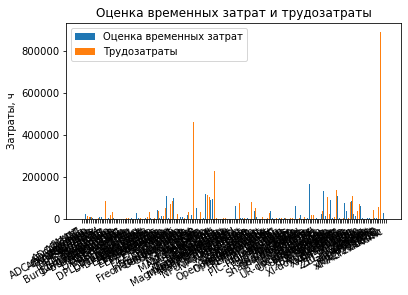

In [4]:
# Построение графика с полными значениями трудозатрат для проектов
# Сначала получаем готовим данные
project_names = sorted(list(result.keys()))
estimated_times = []
spent_times = []
for project_name in project_names:
    estimated_time = 0
    spent_time = 0
    for item in result[project_name]:
        estimated_time += item["estimated_time"]
        spent_time += item["spent_time"]
    estimated_times.append(estimated_time)
    spent_times.append(spent_time)
# Потом рисуем
fig, ax = plt.subplots()
x = np.arange(len(project_names))
width = 0.3
ax.bar(x - width / 2, estimated_times, width, label="Оценка временных затрат")
ax.bar(x + width / 2, spent_times, width, label="Трудозатраты")
ax.set_xticks(x)
ax.set_xticklabels(project_names)
ax.set_title("Оценка временных затрат и трудозатраты")
ax.set_ylabel("Затраты, ч")
ax.legend()
fig.autofmt_xdate()
plt.show()

In [5]:
# Создание таблицы
table = [(project_name, estimated_times[i], spent_times[i]) for i, project_name in enumerate(project_names)]
pd.DataFrame(table, columns=("Проект", "Оценка временных затрат, ч", "Трудозатраты, ч"))

,Проект,"Оценка временных затрат, ч","Трудозатраты, ч"
0,0MALT,0.0,0.00
1,ADC,0.0,0.00
2,ADC-RTL,23535.0,32439.50
3,ADC-analog,7469.0,10481.20
4,ADC-doc,1210.0,6828.76
...,...,...,...
168,uRPC,32011.0,55163.82
169,xMALT2011-18,640422.5,890172.00
170,xMALT2019-20,0.0,0.00
171,xidcusb,27694.5,52531.04


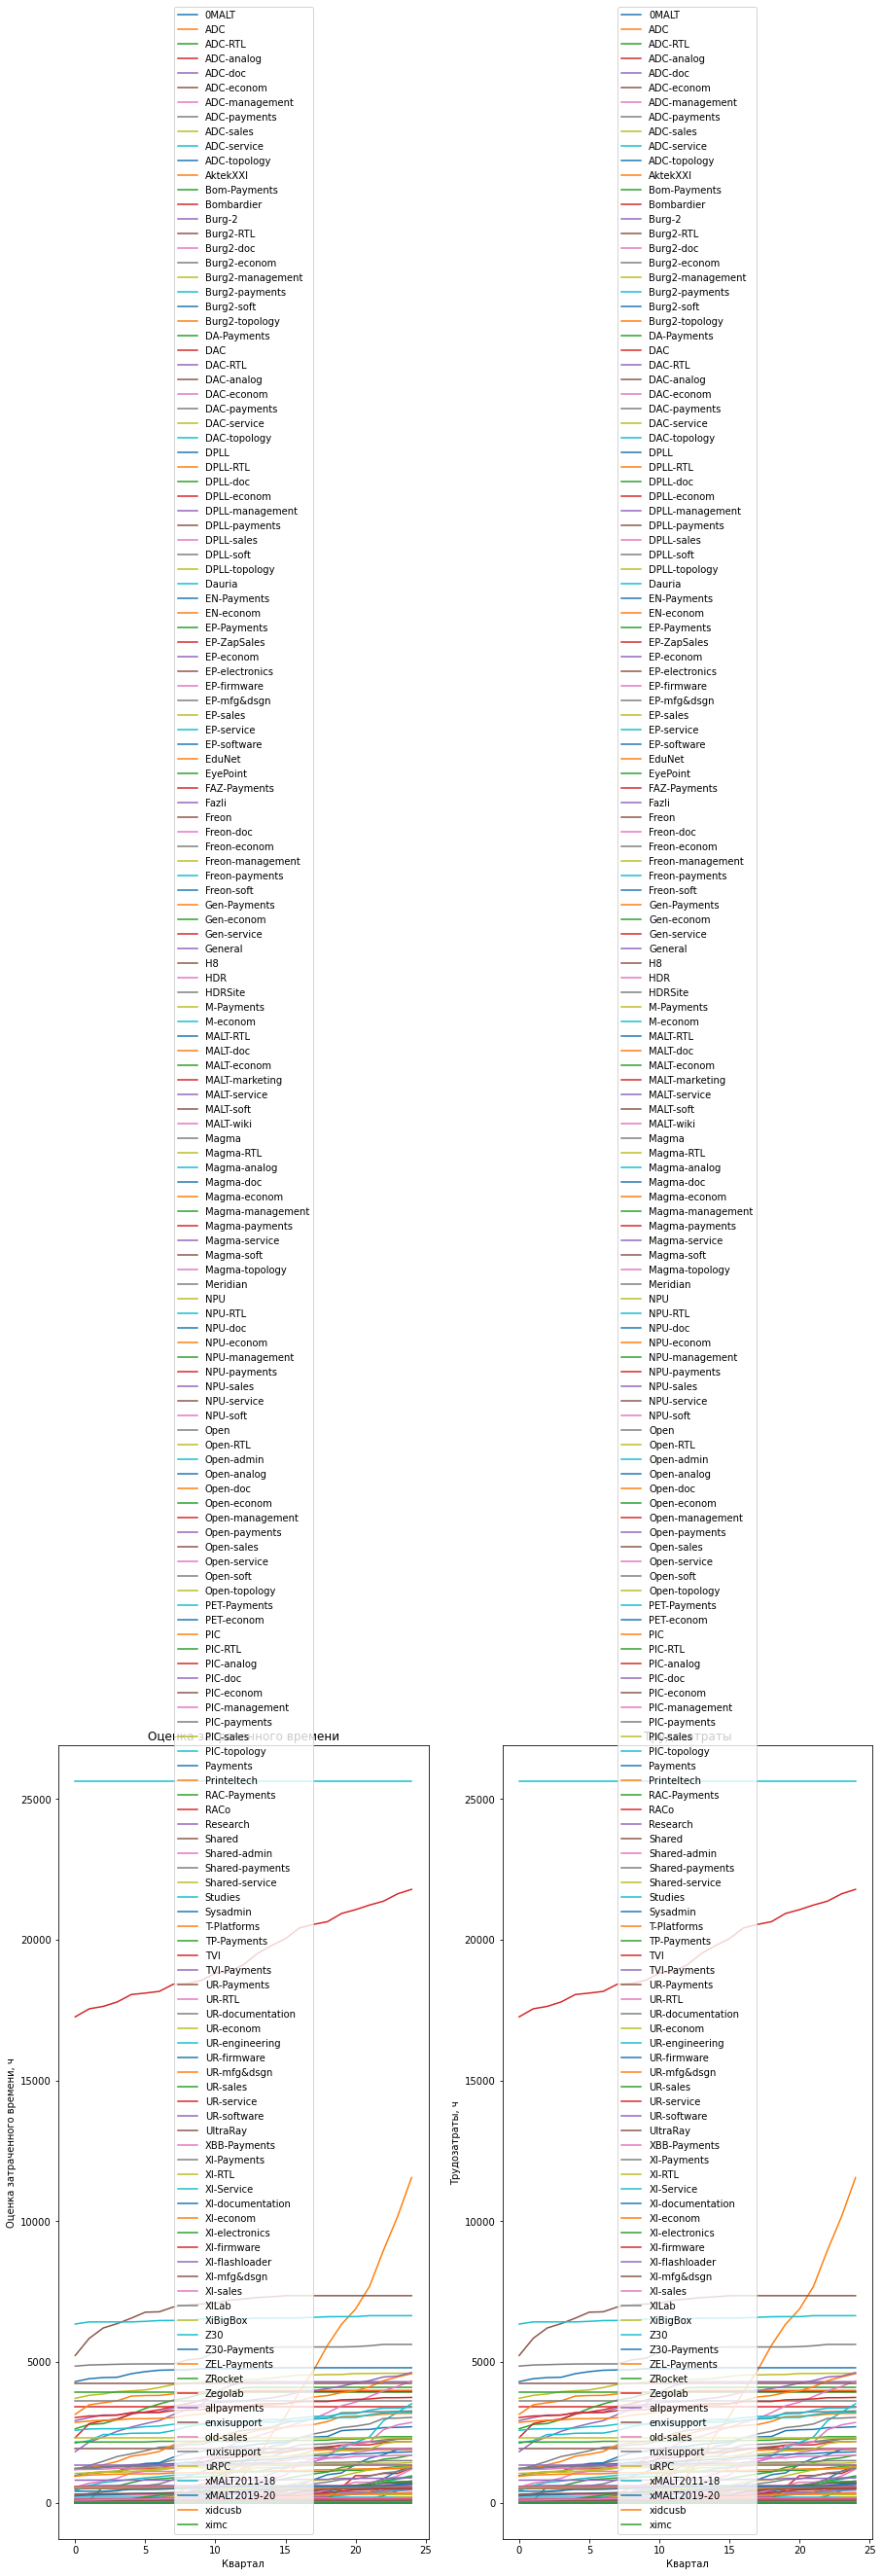

In [6]:
# Постоение графика с линиями
# Сначала готовим данные
project_names = sorted(list(result.keys()))
estimated_times = []
spent_times = []
for project_name in project_names:
    estimated_times.append([item["estimated_time"] for item in result[project_name]])
    spent_times.append([item["estimated_time"] for item in result[project_name]])
# Потом рисуем
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
for index, project in enumerate(project_names):
    ax1.plot(estimated_times[index], label=project)
    ax2.plot(spent_times[index], label=project)
ax1.set_title("Оценка затраченного времени")
ax1.set_xlabel("Квартал")
ax1.set_ylabel("Оценка затраченного времени, ч")
ax1.legend()
ax2.set_title("Трудозатраты")
ax2.set_xlabel("Квартал")
ax2.set_ylabel("Трудозатраты, ч")
ax2.legend()

In [7]:
# Получаем ID и названия всех проектов в ximc
projects = ximc_user.get_projects()
pd.DataFrame(projects, columns=("ID", "Проект"))

,ID,Проект
0,185,0MALT
1,138,ADC
2,212,ADC-analog
3,154,ADC-doc
4,155,ADC-econom
...,...,...
169,111,Z30
170,114,Z30-Payments
171,118,Zegolab
172,119,ZEL-Payments
